#initial setup for pytorch

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device) # should print cuda:0 if setup correctly

cuda:0


# connect to google drive folders 

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
meme_net = "/content/drive/MyDrive/colab_files/meme_net/V1/"
if not os.path.exists(meme_net):
    os.makedirs(meme_net)

Mounted at /content/drive


# unzip meme image set in google drive to add to local runtime

In [ ]:
import shutil
shutil.copy(meme_net + "meme_img_set.zip", "./meme_img_set.zip")
!unzip meme_img_set.zip > /dev/null
MEME_LABELS = sorted(os.listdir("./meme_img_set/train"))
!echo success

Actual-Advice-Mallard	       Confession-Bear		  Peter-Griffin-News
Afraid-To-Ask-Andy	       Futurama-Fry		  Too-Damn-High
Bad-Luck-Brian		       I-Guarantee-It
But-Thats-None-Of-My-Business  Pepperidge-Farm-Remembers


# Setup the dataset

In [ ]:
def get_meme_data(testing=0):
  transform_train = None
  if not testing:
    transform_train = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(240),
      transforms.ToTensor(),
    ])
  else:
    transform_train = transforms.ToTensor()
  
  transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor()
  ])

  trainset = torchvision.datasets.ImageFolder(root="./meme_img_set/train/", transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

  testset = torchvision.datasets.ImageFolder(root="./meme_img_set/test/", transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2) # a warning suggested 2
  
  classes = MEME_LABELS
  return {'train': trainloader, 'test': testloader, 'classes': classes}
data = get_meme_data()

# Visualize data from dataset

torch.Size([8, 3, 240, 240])


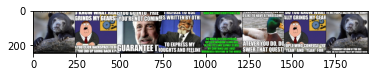

Labels:tensor(4) tensor(8) tensor(6) tensor(9) tensor(4) tensor(0) tensor(8) tensor(4)
torch.Size([8, 3, 240, 240])
torch.Size([8, 172800])


In [ ]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

# define training for model


In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses

def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          print("labels")
          print(labels)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          print("predicted:")
          print(predicted.cpu().numpy())
          print("meme:")
          for fuck in predicted.cpu().numpy():
            print(MEME_LABELS[fuck])
          
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [ ]:
!mkdir meme_img_set/apply/
%cd meme_img_set/apply/
!ls ../train/ | xargs -I % mkdir "%"
%cd ../../

/content/meme_img_set/apply
/content


# load and teach pretrained model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[0,     1] loss: 2.554
[0,     2] loss: 2.062
[0,     3] loss: 1.422
[0,     4] loss: 0.868
[0,     5] loss: 0.453
[0,     6] loss: 0.291
[0,     7] loss: 0.156
[0,     8] loss: 0.079
[0,     9] loss: 0.050
[1,     1] loss: 0.042
[1,     2] loss: 0.025
[1,     3] loss: 0.019
[1,     4] loss: 0.015
[1,     5] loss: 0.006
[1,     6] loss: 0.024
[1,     7] loss: 0.008
[1,     8] loss: 0.017
[1,     9] loss: 0.005
[2,     1] loss: 0.012
[2,     2] loss: 0.015
[2,     3] loss: 0.004
[2,     4] loss: 0.004
[2,     5] loss: 0.003
[2,     6] loss: 0.011
[2,     7] loss: 0.002
[2,     8] loss: 0.003
[2,     9] loss: 0.012
[3,     1] loss: 0.002
[3,     2] loss: 0.002
[3,     3] loss: 0.004
[3,     4] loss: 0.008
[3,     5] loss: 0.009
[3,     6] loss: 0.003
[3,     7] loss: 0.001
[3,     8] loss: 0.003
[3,     9] loss: 0.006
[4,     1] loss: 0.001
[4,     2] loss: 0.002
[4,     3] loss: 0.002
[4,     4] loss: 0.001
[4,     5] loss: 0.006
[4,     6] loss: 0.004
[4,     7] loss: 0.006
[4,     8] 

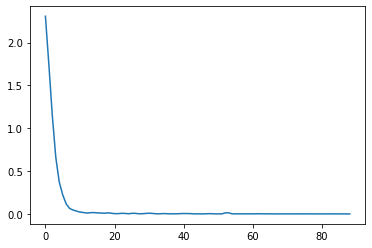

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(512, len(MEME_LABELS))
model_losses = train(model, data["train"], epochs = 10, lr=0.01, print_every=1, checkpoint_path=meme_net)
print("Testing accuracy: %f" % accuracy(model, data['test']))
plt.plot(smooth(model_losses, 2))

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor()
  ])

applySet = torchvision.datasets.ImageFolder(root="./meme_img_set/apply/", transform=transform_test)
applyLoader = torch.utils.data.DataLoader(applySet, batch_size=128, shuffle=False, num_workers=2) # a warning suggested 2

print("Testing accuracy: %f" % accuracy(model, applyLoader))

labels
tensor([0, 2, 2, 5, 8], device='cuda:0')
predicted:
[0 2 2 5 8]
meme:
Actual-Advice-Mallard
Bad-Luck-Brian
Bad-Luck-Brian
Futurama-Fry
Peter-Griffin-News
Testing accuracy: 1.000000


In [ ]:
print(MEME_LABELS)

['Actual-Advice-Mallard', 'Afraid-To-Ask-Andy', 'Bad-Luck-Brian', 'But-Thats-None-Of-My-Business', 'Confession-Bear', 'Futurama-Fry', 'I-Guarantee-It', 'Pepperidge-Farm-Remembers', 'Peter-Griffin-News', 'Too-Damn-High']
